# Neo4J GDS 

https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/

## Node embeddings

Node embedding algorithms compute low-dimensional vector representations of nodes in a graph. These vectors, also called embeddings, can be used for machine learning. The Neo4j Graph Data Science library contains the following node embedding algorithms:

#### Production Quaility
- FastRP

#### Beta
- GraphSage
- Node2Vec
- HashGNN

## Generalization across graphs
Node embeddings are typically used as input to downstream machine learning tasks such as node classification, link prediction and kNN similarity graph construction.

Often the graph used for constructing the embeddings and training the downstream model differs from the graph on which predictions are made. Compared to normal machine learning where we just have a stream of independent examples from some distribution, we now have graphs that are used to generate a set of labeled examples. Therefore, we must ensure that the set of training examples is representative of the set of labeled examples derived from the prediction graph. For this to work, certain things are required of the embedding algorithm, and we denote such algorithms as inductive

# FastRP

https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/

Fast Random Projection, or FastRP for short, is a node embedding algorithm in the family of random projection algorithms. These algorithms are theoretically backed by the Johnsson-Lindenstrauss lemma according to which one can project n vectors of arbitrary dimension into O(log(n)) dimensions and still approximately preserve pairwise distances among the points. In fact, a linear projection chosen in a random way satisfies this property.

Such techniques therefore allow for aggressive dimensionality reduction while preserving most of the distance information. The FastRP algorithm operates on graphs, in which case we care about preserving similarity between nodes and their neighbors. This means that two nodes that have similar neighborhoods should be assigned similar embedding vectors. Conversely, two nodes that are not similar should be not be assigned similar embedding vectors.

### Johnson–Lindenstrauss lemma
https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma

### Node properties
Most real-world graphs contain node properties which store information about the nodes and what they represent. The FastRP algorithm in the GDS library extends the original FastRP algorithm with a capability to take node properties into account. The resulting embeddings can therefore represent the graph more accurately.

The node property aware aspect of the algorithm is configured via the parameters featureProperties and propertyRatio. Each node property in featureProperties is associated with a randomly generated vector of dimension propertyDimension, where propertyDimension = embeddingDimension * propertyRatio. Each node is then initialized with a vector of size embeddingDimension formed by concatenation of two parts:

The first part is formed like in the standard FastRP algorithm,

The second one is a linear combination of the property vectors, using the property values of the node as weights.

The algorithm then proceeds with the same logic as the FastRP algorithm. Therefore, the algorithm will output arrays of size embeddingDimension. The last propertyDimension coordinates in the embedding captures information about property values of nearby nodes (the "property part" below), and the remaining coordinates (embeddingDimension - propertyDimension of them; "topology part") captures information about nearby presence 

of nodes.

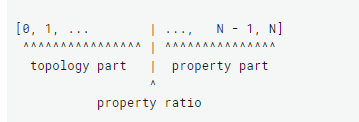

### Example
https://colab.research.google.com/github/neo4j/graph-data-science-client/blob/main/examples/fastrp-and-knn.ipynb

In [1]:
from langchain.graphs import Neo4jGraph

graph = Neo4jGraph(
    url="bolt://100.26.193.165:7687",
    username="neo4j",
    password="tie-rubbish-word"
)

r = graph.query("""MATCH (n:Airport {city:"Los Angeles"}) RETURN n""")
print(r)

[{'n': {'altitude': 127, 'descr': 'Los Angeles International Airport', 'longest': 12091, 'iata': 'LAX', 'city': 'Los Angeles', 'icao': 'KLAX', 'location': POINT(-118.4079971 33.94250107), 'id': '13', 'pagerank': 8.193558075446687, 'runways': 4, 'region_airports': 1, 'country_airports': 1}}]


In [3]:
r = graph.query("""CALL gds.graph.project(
    'Airports',
    'Airport', 
    {
    HAS_ROUTE:   {    
        orientation: 'UNDIRECTED',
        properties: 'distance'
    }
    }
    ,
   { nodeProperties: ['longest','country_airports','altitude', 'region_airports', 'pagerank', 'runways'] } 
);""")
print(r)

[{'nodeProjection': {'Airport': {'label': 'Airport', 'properties': {'country_airports': {'property': 'country_airports', 'defaultValue': None}, 'region_airports': {'property': 'region_airports', 'defaultValue': None}, 'pagerank': {'property': 'pagerank', 'defaultValue': None}, 'runways': {'property': 'runways', 'defaultValue': None}, 'altitude': {'property': 'altitude', 'defaultValue': None}, 'longest': {'property': 'longest', 'defaultValue': None}}}}, 'relationshipProjection': {'HAS_ROUTE': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'distance': {'aggregation': 'DEFAULT', 'property': 'distance', 'defaultValue': None}}, 'type': 'HAS_ROUTE'}}, 'graphName': 'Airports', 'nodeCount': 3503, 'relationshipCount': 92778, 'projectMillis': 500}]


In [4]:
r = graph.query("""CALL gds.fastRP.stream.estimate('Airports', {embeddingDimension: 256})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory""")
print(r)

[{'nodeCount': 3503, 'relationshipCount': 92778, 'bytesMin': 11097792, 'bytesMax': 11097792, 'requiredMemory': '10837 KiB'}]


In [5]:
# unweighted
r = graph.query("""CALL gds.fastRP.stream('Airports',
  {
    embeddingDimension: 256,
    randomSeed: 42
  }
)
YIELD nodeId, embedding
""")

In [8]:
print(r[0])

{'nodeId': 8627, 'embedding': [0.03484951704740524, -0.02616049163043499, -0.05085065960884094, -0.03925191983580589, 0.07475659996271133, -0.02048027142882347, 0.05792176350951195, -0.07685893774032593, 0.291058748960495, 0.08514612913131714, -0.15322786569595337, 0.059608981013298035, 0.0786915272474289, -0.08643384277820587, 0.0498017892241478, -0.22369259595870972, -0.05722637474536896, 0.18671193718910217, -0.10880599915981293, -0.18699537217617035, 0.07331272214651108, 0.03479019179940224, 0.11827300488948822, 0.09609447419643402, -0.12170525640249252, 0.06478095054626465, -0.004645588807761669, -0.2872890830039978, 0.058145053684711456, 0.11094865202903748, 0.10485120117664337, 0.023339737206697464, 0.1226349025964737, -0.07385698705911636, -0.019326893612742424, 0.06074300408363342, 0.06967775523662567, -0.0822642520070076, -0.12171635776758194, 0.052760809659957886, -0.020920224487781525, 0.14200058579444885, -0.05876987427473068, -0.11199477314949036, 0.06728161126375198, -0.

In [9]:
# weighted
r = graph.query("""CALL gds.fastRP.stream('Airports',
  {
    embeddingDimension: 256,
    randomSeed: 42,
    relationshipWeightProperty: 'distance'
  }
)
YIELD nodeId, embedding
""")

In [10]:
print(r[0])

{'nodeId': 8627, 'embedding': [0.03580985218286514, -0.036011260002851486, 0.031647056341171265, 0.04367472231388092, 0.07375358045101166, -0.04210198298096657, 0.013596644625067711, -0.11564319580793381, 0.297812283039093, 0.07166710495948792, -0.09110728651285172, 0.17944592237472534, 0.08549007773399353, -0.14020967483520508, -0.11156188696622849, -0.13838014006614685, -0.019016234204173088, 0.1950339823961258, -0.0876714438199997, -0.10531874001026154, -0.012475626543164253, 0.10900287330150604, 0.024276835843920708, -0.01222410798072815, -0.18405857682228088, 0.07853298634290695, 0.06455501914024353, -0.18589136004447937, -0.027108311653137207, 0.07346668094396591, 0.18880373239517212, -0.010766295716166496, 0.12735310196876526, -0.2244969606399536, 0.023201650008559227, 0.11452081799507141, 0.14434504508972168, 0.007650021463632584, -0.13751119375228882, 0.14813318848609924, -0.09538495540618896, 0.16589194536209106, 0.05756119266152382, 0.02495419979095459, 0.13501812517642975, 

# GraphSAGE

https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/graph-sage/

GraphSAGE is an inductive algorithm for computing node embeddings. GraphSAGE is using node feature information to generate node embeddings on unseen nodes or graphs. Instead of training individual embeddings for each node, the algorithm learns a function that generates embeddings by sampling and aggregating features from a node’s local neighborhood.

# Node2Vec

https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/node2vec/

Node2Vec is a node embedding algorithm that computes a vector representation of a node based on random walks in the graph. The neighborhood is sampled through random walks. Using a number of random neighborhood samples, the algorithm trains a single hidden layer neural network. The neural network is trained to predict the likelihood that a node will occur in a walk based on the occurrence of another node.

# HashGNN

https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/hashgnn/

HashGNN is a node embedding algorithm which resembles Graph Neural Networks (GNN) but does not include a model or require training. The neural networks of GNNs are replaced by random hash functions, in the flavor of the min-hash locality sensitive hashing. Thus, HashGNN combines ideas of GNNs and fast randomized algorithms.

The GDS implementation of HashGNN is based on the paper "Hashing-Accelerated Graph Neural Networks for Link Prediction", and further introduces a few improvements and generalizations. The generalizations include support for embedding heterogeneous graphs; relationships of different types are associated with different hash functions, which allows for preserving relationship-typed graph topology. Moreover, a way to specify how much embeddings are updated using features from neighboring nodes versus features from the same node can be configured via neighborInfluence.

The runtime of this algorithm is significantly lower than that of GNNs in general, but can still give comparable embedding quality for certain graphs as shown in the original paper. Moreover, the heterogeneous generalization also gives comparable results when compared to the paper "Graph Transformer Networks" when benchmarked on the same datasets.